# Linear Regression to predict cholesterol level

/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Script/Nguyen_data_processor.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace = True)


Raw data correlation with 'chol':
chol        1.000000
thalch      0.236121
trestbps    0.092853
ca          0.051606
oldpeak     0.047734
age        -0.086234
num        -0.231547
Name: chol, dtype: float64

Cleaned data correlation with 'chol':
chol        1.000000
age         0.074192
trestbps    0.071768
num         0.058104
oldpeak     0.040437
thalch     -0.039005
Name: chol, dtype: float64


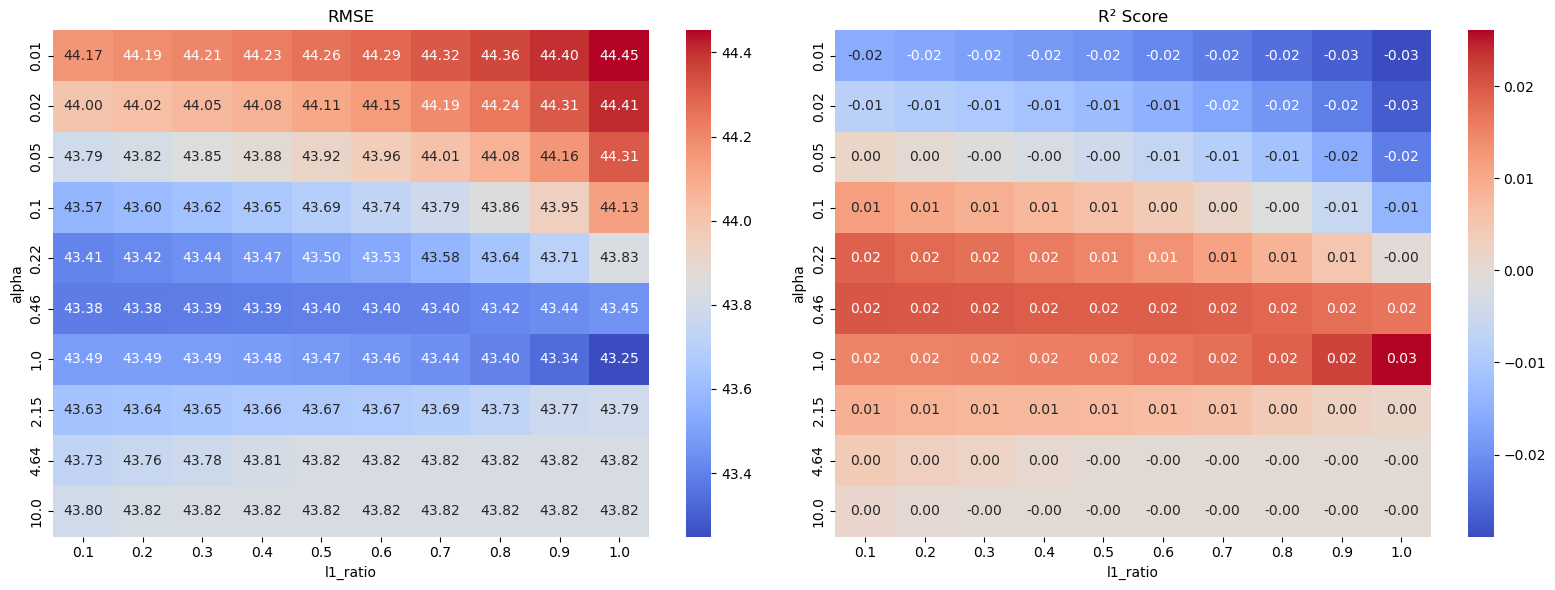

Best alpha and l1_ratio for minimum RMSE: 1.0, 1.0
Best alpha and l1_ratio for maximum R2: 1.0, 1.0


In [ ]:
# ======================= Importing packages ==============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import Nguyen_data_processor as dp  # Custom preprocessing module


# ====================== 1. Load & Clean Data ============================
# Load raw dataset
data = pd.read_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/heart_disease_uci.csv')

# Create a copy for cleaning
clean_data = data.copy()

# Convert the weird values in cholesterol columns (is 0) to NaN for imputing
clean_data.loc[clean_data['chol'] == 0, 'chol'] = np.nan

# Apply data cleaning functions
clean_data = dp.remove_missing_columns(clean_data)
clean_data = dp.impute_missing_values(clean_data)
clean_data = dp.remove_duplicates(clean_data)
clean_data = dp.remove_redundant_features(clean_data)
clean_data = dp.impute_outlier(clean_data, method='mean', threshold=2.5)

# Save cleaned dataset
clean_data.to_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/cleaned_heart_disease_uci.csv', index=False)


# ========================= 2. Explore Correlation ============================
# Use .corr() to check for possible correlation before and after cleaning. 
# This would give context to model evaluation using RMSE and R2
print("Raw data correlation with 'chol':")
print(data.corr(numeric_only=True)['chol'].sort_values(ascending=False))

print("\nCleaned data correlation with 'chol':")
print(clean_data.corr(numeric_only=True)['chol'].sort_values(ascending=False))


# ======================== 3. Prepare Modeling Data ============================
# Drop any rows with NA values
reg_data = clean_data.copy()
reg_data.dropna(inplace = True)

# Split data into features and target
target = reg_data['chol']
features = reg_data.drop(columns = ['chol'])

# Normalize feature data
features = dp.normalize_data(features, method = 'minmax')

# if the column is not numeric, encode it (one-hot)
cat_cols = features.select_dtypes(include='object').columns
features = pd.get_dummies(features, columns = cat_cols, prefix = cat_cols)

# Splitting data set for training and testing
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size = 0.8, random_state = 42)


# ============================ 4. Hyperparameter Grid Search ============================
# Make a list of values for alpha and l1_ratio
alphas = np.logspace(-2, 1, 10)
l1_ratios = np.linspace(0.1, 1.0, 10)

# Create a 2D arrays to store subsequent RMSE and R2 values in, 
# with respect to each combination of alpha and l1-ratio
rmse_values_array = np.zeros((len(alphas), len(l1_ratios)))
r2_values_array = np.zeros((len(alphas), len(l1_ratios)))

# Create and fit the model using those 100 combinations of alphas and l1_ratio
for i, alpha_value in enumerate(alphas):
    for j, l1_ratio_value in enumerate(l1_ratios):

        # Fitting ElasticNet model
        reg_model = ElasticNet(alpha=alpha_value, l1_ratio=l1_ratio_value)
        reg_model.fit(x_train, y_train)

        # Predict value and assess model
        y_predict = reg_model.predict(x_test)
        rmse_values_array[i,j] = np.sqrt(mean_squared_error(y_test, y_predict))
        r2_values_array[i,j] = r2_score(y_test, y_predict)


# ============================== 5. Visualize Results ================================
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# RMSE heatmap
sns.heatmap(rmse_values_array, annot=True, fmt=".2f",
            xticklabels=np.round(l1_ratios, 2),
            yticklabels=np.round(alphas, 2),
            cmap="coolwarm", ax=axs[0])
axs[0].set_title("RMSE")
axs[0].set_xlabel("l1_ratio")
axs[0].set_ylabel("alpha")

# R2 heatmap
sns.heatmap(r2_values_array, annot=True, fmt=".2f",
            xticklabels=np.round(l1_ratios, 2),
            yticklabels=np.round(alphas, 2),
            cmap="coolwarm", ax=axs[1])
axs[1].set_title("R² Score")
axs[1].set_xlabel("l1_ratio")
axs[1].set_ylabel("alpha")

plt.tight_layout()
plt.show()


# ============================= 6. Find best config =====================================
# Find the indices of the cell with the minimum RMSE
# Use np.argmin() to find the indices of the minimum value in the 2D array, specifying the shape of the array
# First, it flattens the array into 1D dimension:
#       [1,2,3]
#       [4,5,6]     => [1,2,3,4,5,6,7,8,9]
#       [7,8,9]
# Then it finds the minimum value and return the index in the flattened array. In this case, it would be index 0 (value 1)
# It also returns the shape of the original array.
# We then use np.unravel_index() to convert the index to match the original 2D array, returning a tuple of the input flattened index.
#       [1,2,3]
#       [4,5,6]     => [1,2,3,4,5,6,7,8,9]
#       [7,8,9]     =>  0 = [0,0]
min_rmse_idx = np.unravel_index(np.argmin(rmse_values_array), rmse_values_array.shape)
# After getting the 2D index for best config, we can extract the value of each axis (alpha and l1_ratio)
alpha_min_rmse = alphas[min_rmse_idx[0]]
l1_ratio_min_rmse = l1_ratios[min_rmse_idx[1]]

# Find the indices of the cell with the maximum R2
max_r2_idx = np.unravel_index(np.argmax(r2_values_array), r2_values_array.shape)
alpha_max_r2 = alphas[max_r2_idx[0]]
l1_ratio_max_r2 = l1_ratios[max_r2_idx[1]]

# Print out best config:
print(f"Best alpha and l1_ratio for minimum RMSE: {alpha_min_rmse}, {l1_ratio_min_rmse}")
print(f"Best alpha and l1_ratio for maximum R2: {alpha_max_r2}, {l1_ratio_max_r2}")


# Minmax scaler works better than standard scaler

AUC-ROC: 0.9152485819152486
Precision-Recall AUC: 0.9206653770378692
Accuracy: 0.8516129032258064
F1 score: 0.8606060606060606


/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Script/Nguyen_data_processor.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace = True)


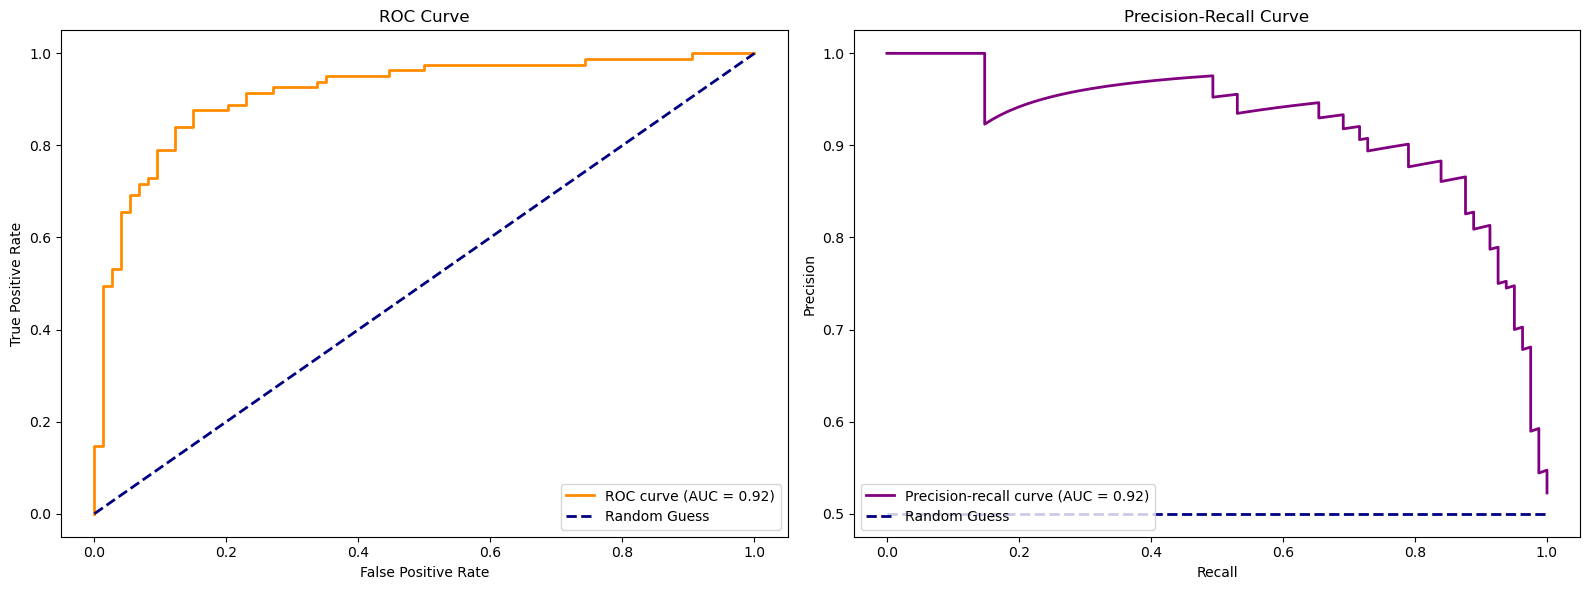

In [72]:
# ======================= Importing packages ==============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score

# Setting the prediction threshold for classification (put it here so it's easier to change)
predict_threshold = 0.5


# ====================== 1. Load & Clean Data ============================
# Load raw dataset
data = pd.read_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/heart_disease_uci.csv')

# Create a copy for cleaning
clean_data = data.copy()

# Convert the weird values in cholesterol columns (is 0) to NaN for imputing
clean_data.loc[clean_data['chol'] == 0, 'chol'] = np.nan

# Apply data cleaning functions
clean_data = dp.remove_missing_columns(clean_data)
clean_data = dp.impute_missing_values(clean_data)
clean_data = dp.remove_duplicates(clean_data)
clean_data = dp.remove_redundant_features(clean_data)
clean_data = dp.impute_outlier(clean_data, method='mean', threshold=2.5)

# Save cleaned dataset
clean_data.to_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/cleaned_heart_disease_uci.csv', index=False)


# ======================== 2. Prepare Modeling Data ============================
# Drop any rows with NA values
reg_data = clean_data.copy()

# The column "num" has values as [0,1,2,3,4] indicating severity of heart disease
#       0: No significant heart disease
#       1, 2, 3, 4: Presence of heart disease with increasing severity
# We want to check for presence of heart disease, so [1, 2, 3, 4] will all be converted to 1 (presence) 
# reg_data.loc[~(reg_data['num'].isin([0,1])), 'num'] =  float('NaN')
reg_data.dropna(inplace = True)
reg_data.loc[(reg_data['num'].isin([1,2,3,4])), 'num'] = 1

# Split data into features and target
target = reg_data['num'].astype('category')
features = reg_data.drop(columns = ['num'])

# Normalize feature data
features = dp.normalize_data(features, method = 'standard')

# if the column is not numeric, encode it (one-hot)
cat_cols = features.select_dtypes(include='object').columns
features = pd.get_dummies(features, columns = cat_cols, prefix = cat_cols)

# Splitting data set for training and testing
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size = 0.8, random_state = 42)


# ====================== 3. Logistic Regression Model ==========================
# Make logistic regression model
logistic_model = LogisticRegression(C = 0.05, random_state=42)  # C (inverse regularization) controls the strength of regularization
                                                                # Larger C => stronger penalty => encourages simpler model and prevent overfitting
                                                                # but may lead to underfitting
                                                                # Smaller C => less regularization => keep the complexity of the model
logistic_model.fit(x_train, y_train)

# Predict the propability of each classification
y_predict = logistic_model.predict_proba(x_test)[:, 1] 

# Compute ROC curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_predict)
average_precision = average_precision_score(y_test, y_predict)

# Convert probabilities to binary labels using threshold
y_predict_binary = (y_predict >= predict_threshold).astype(int)
y_test_binary = y_test.astype(int)

# Accuracy and F1
accuracy_log = accuracy_score(y_test_binary, y_predict_binary)
f1 = f1_score(y_test_binary, y_predict_binary)

# Print results
print(f"AUC-ROC: {roc_auc}")
print(f"Precision-Recall AUC: {average_precision}")
print(f"Accuracy: {accuracy_log}")
print(f"F1 score: {f1}")


# ============================= 4. Visualization ===============================
fig, axs = plt.subplots(1,2,figsize=(16,6))

# Make ROC plot
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve')
axs[0].legend(loc='lower right')

# Make precision-recall plot
axs[1].plot(recall, precision, color='purple', lw=2, label='Precision-recall curve (AUC = %0.2f)' % average_precision)
axs[1].plot([0, 1], [0.5, 0.5], color='navy', lw=2, linestyle='--', label='Random Guess')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc='lower left')

# Print plot
plt.tight_layout()
plt.show()

# PREDICTION THRESHOLD
## Convert probabilities to binary labels using threshold
    y_predict_binary = (y_predict >= predict_threshold).astype(int)
## Threshold of 0.5 seemed to be the optimal parameter. Increasing or decreasing the threshold reduced the model's accuracy and f1 score.


# PENALTY
# If removed all values that are not 0 and 1 in "num" column:
# In LogisticRegression(), adding the penalty may have adverse effects on the model.
# The following used C = 0.001 and solver = 'liblinear'
Without regularization, the model was at:
    AUC-ROC:                0.90
    Precision-Recall AUC:   0.91
    Accuracy:               0.80
    F1 score:               0.82
## For L1 regularization:
    AUC-ROC:                0.5
    Precision-Recall AUC:   0.52
    Accuracy:               0.52
    F1 score:               0.69
## For L2 regularization:
    AUC-ROC:                0.90
    Precision-Recall AUC:   0.91
    Accuracy:               0.80
    F1 score:               0.81

# At C = 0.03, the model improved slightly but not very noticeable. Also found no difference between L2 regularization (using all solver) and "None"
    AUC-ROC:                0.91
    Precision-Recall AUC:   0.92
    Accuracy:               0.83
    F1 score:               0.84

# If normalization used StandardScaler() instead of MinMaxScaler():
# At C = 0.03, the model improved slightly but not very noticeable. Also found no difference between L2 regularization (using all solver) and "None"
    AUC-ROC:                0.92
    Precision-Recall AUC:   0.92
    Accuracy:               0.85
    F1 score:               0.86


AUC-ROC: 0.9049049049049049
Precision-Recall AUC: 0.8978846594740317
Accuracy: 0.8258064516129032
F1 score: 0.8439306358381503


/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Script/Nguyen_data_processor.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace = True)


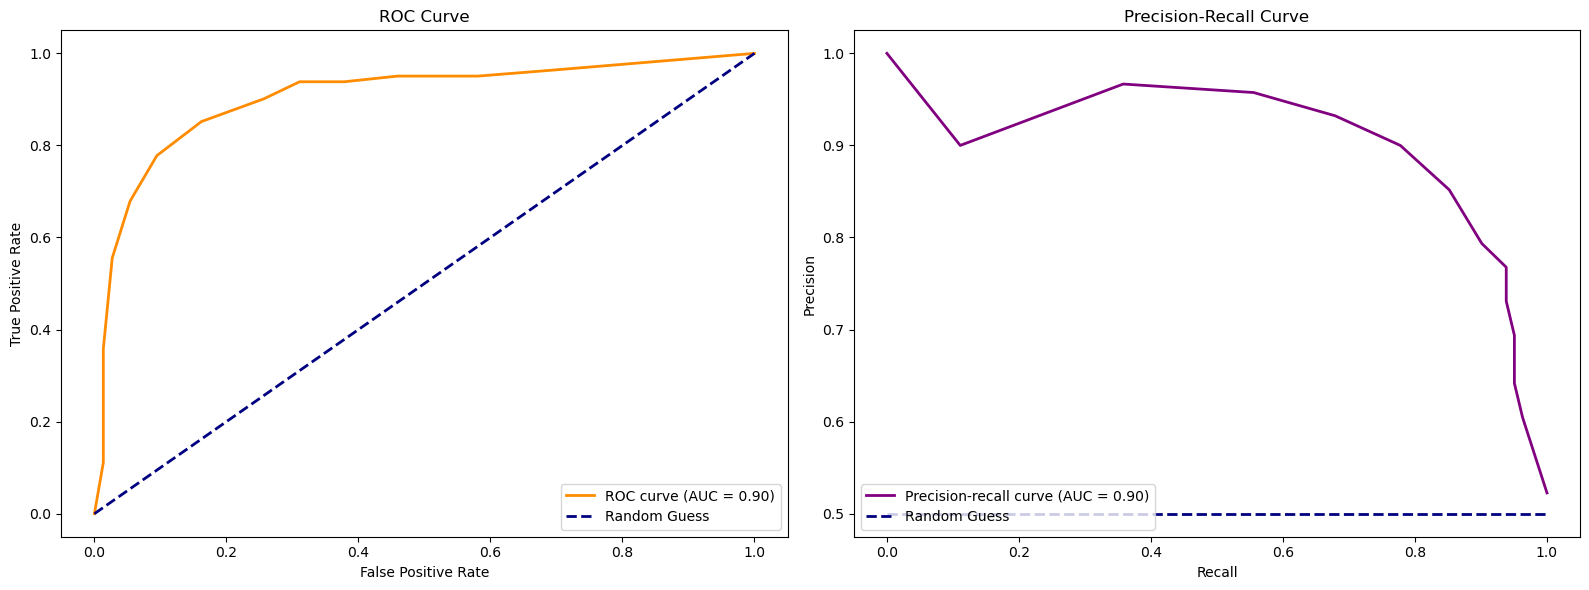

In [ ]:
# ======================= Importing packages ==============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score

predict_threshold = 0.5


# ====================== 1. Load & Clean Data ============================
# Load raw dataset
data = pd.read_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/heart_disease_uci.csv')

# Create a copy for cleaning
clean_data = data.copy()

# Convert the weird values in cholesterol columns (is 0) to NaN for imputing
clean_data.loc[clean_data['chol'] == 0, 'chol'] = np.nan

# Apply data cleaning functions
clean_data = dp.remove_missing_columns(clean_data)
clean_data = dp.impute_missing_values(clean_data)
clean_data = dp.remove_duplicates(clean_data)
clean_data = dp.remove_redundant_features(clean_data)
clean_data = dp.impute_outlier(clean_data, method='mean', threshold=2.5)

# Save cleaned dataset
clean_data.to_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/cleaned_heart_disease_uci.csv', index=False)


# ======================== 2. Prepare Modeling Data ============================
# Drop any rows with NA values
reg_data = clean_data.copy()

# The column "num" has values as [0,1,2,3,4] indicating severity of heart disease
#       0: No significant heart disease
#       1, 2, 3, 4: Presence of heart disease with increasing severity
# We want to check for presence of heart disease, so [1, 2, 3, 4] will all be converted to 1 (presence) 
# reg_data.loc[~(reg_data['num'].isin([0,1])), 'num'] =  float('NaN')
reg_data.dropna(inplace = True)
reg_data.loc[(reg_data['num'].isin([1,2,3,4])), 'num'] = 1

# Split data into features and target
target = reg_data['num'].astype('category')
features = reg_data.drop(columns = ['num'])

# Normalize feature data
features = dp.normalize_data(features, method = 'standard')

# if the column is not numeric, encode it (one-hot)
cat_cols = features.select_dtypes(include='object').columns
features = pd.get_dummies(features, columns = cat_cols, prefix = cat_cols)

# Splitting data set for training and testing
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size = 0.8, random_state = 42)


# ====================== 3. k-Nearest Neighbour Model ==========================
# Make kNN model
knn_model = KNeighborsClassifier(n_neighbors=12,metric='manhattan')
knn_model.fit(x_train, y_train)

# Predict the propability of each classification
y_predict = knn_model.predict_proba(x_test)[:, 1] 

# Compute ROC curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_predict)
average_precision = average_precision_score(y_test, y_predict)

# Convert probabilities to binary labels using threshold
y_predict_binary = (y_predict >= predict_threshold).astype(int)
y_test_binary = y_test.astype(int)

# Accuracy and F1
accuracy_log = accuracy_score(y_test_binary, y_predict_binary)
f1 = f1_score(y_test_binary, y_predict_binary)

# Print results
print(f"AUC-ROC: {roc_auc}")
print(f"Precision-Recall AUC: {average_precision}")
print(f"Accuracy: {accuracy_log}")
print(f"F1 score: {f1}")


# =============================== 4. Visualization ==================================
fig, axs = plt.subplots(1,2,figsize=(16,6))

# Make ROC plot
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve')
axs[0].legend(loc='lower right')

# Make precision-recall plot
axs[1].plot(recall, precision, color='purple', lw=2, label='Precision-recall curve (AUC = %0.2f)' % average_precision)
axs[1].plot([0, 1], [0.5, 0.5], color='navy', lw=2, linestyle='--', label='Random Guess')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc='lower left')

# Print plot
plt.tight_layout()
plt.show()

# For KNN, distance metrics have low influence on model, but 'manhattan' seems to yield best results

# Propability threshold of 0.5 seems to be most optimal

n_neighbour: 12
AUC-ROC: 0.8858858858858859
Precision-Recall AUC: 0.8850793653744299
Accuracy: 0.7806451612903226
F1 score: 0.8

n_neighbour: 10
AUC-ROC: 0.8918084751418085
Precision-Recall AUC: 0.8856254228251097
Accuracy: 0.7935483870967742
F1 score: 0.8181818181818182

n_neighbour: 9
AUC-ROC: 0.8820487153820487
Precision-Recall AUC: 0.8757561854625001
Accuracy: 0.8129032258064516
F1 score: 0.8284023668639053

n_neighbour: 8
AUC-ROC: 0.8718718718718719
Precision-Recall AUC: 0.8577345454451875
Accuracy: 0.7870967741935484
F1 score: 0.8114285714285714

n_neighbour: 5
AUC-ROC: 0.8660326993660327
Precision-Recall AUC: 0.8369696502396371
Accuracy: 0.8129032258064516
F1 score: 0.8242424242424242
